In [1]:
#@title Import Libraries

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
import os
import pandas as pd
import imageio
from IPython.display import Image
from multiprocessing import Pool



In [2]:
species_colors = {
    'G_off': 'blue',
    'G_on': 'orange',
    'R_n': 'green',
    'R_c': 'red',
    'P': 'purple'
}

# TODO
- simulate multiple cells to get statistics
- Make this notebook user friendly with description
- convert the simulation to something more realistic. add noise, use protein count as indicator of protein concentration.
- add time stamp 

In [3]:
class GeneExpressionSimulator:
    def __init__(self, params):
        self.TS_state = False
        self.RNAs = {}
        self.Proteins = {}
        self.next_rna_id = 1
        self.next_protein_id = 1
        self.rates = params
        self.simulation_type = params.get('simulation_type', '3D')  # Default to '3D' if not specified
        dim = 2 if self.simulation_type == '2D' else 3
        simulation_volume_size = params['simulation_volume_size'][:dim]
        center_of_box = np.array(simulation_volume_size) / 2
        self.center_of_box = center_of_box
        self.simulation_volume_size = simulation_volume_size
        self.nucleus_mask = np.zeros(simulation_volume_size, dtype=bool)
        self.cytosol_mask = np.zeros(simulation_volume_size, dtype=bool)
        if params['position_TS']=='center':
            self.transcription_site = center_of_box
        else:
            self.transcription_site = self.find_random_TS_position_inside_nucleus(params)        
        self.total_time = params['total_time']
        self.RNA_trajectories = {}  # To store RNA positions over time.
        self.Protein_trajectories = {}  # To store Protein positions over time.
        self.frame_rate =  params['frame_rate']    # Save data every 1 second
        self.next_save_time = 0  # Time for next save
        self.time_steps = []  # To store time steps at specified frame rate
        self.TS_state = False  # Initial state of the Transcription Site (TS)
        self.TS_trajectory = []  # To store TS trajectory with time step and position
        self.transport_rate = params['transport_rate']
        self.small_distance_outside_nucleus = 1 # Small distance outside nucleus for RNA transport
        self.transport_zone_threshold = 5 # Threshold distance for RNA near nuclear envelope, in pixels
        self.simulation_type = params['simulation_type'] # Type of simulation. options: '3D', '2D'
        self.movement_protein_into_nucleus = params['movement_protein_into_nucleus']  # Allow protein movement in nucleus
    
    def find_random_TS_position_inside_nucleus(self):
        dim = 2 if self.simulation_type == '2D' else 3
        # Adjust for dimensionality of simulation_volume_size
        volume_size = np.array(self.simulation_volume_size[:dim])
        while True:
            random_pos = np.random.rand(dim) * volume_size  # Ensure volume_size matches dimension
            if self.is_within_nucleus({'position': random_pos.tolist()}):
                return random_pos.tolist()
        
    def save_state(self, current_time):
        current_time_int = int(current_time)  # Use float to store precise time, including fractions of seconds
        self.time_steps.append(current_time_int)
        for rna_id, rna_info in self.RNAs.items():
            if rna_id not in self.RNA_trajectories:
                self.RNA_trajectories[rna_id] = []
            rna_snapshot = rna_info.copy()
            rna_snapshot['time'] = current_time_int
            rna_snapshot['id'] = rna_id  # Explicitly include 'id'
            rna_snapshot['position'] = self.RNAs[rna_id]['position']
            self.RNA_trajectories[rna_id].append(rna_snapshot)
        for protein_id, protein_info in self.Proteins.items():
            if protein_id not in self.Protein_trajectories:
                self.Protein_trajectories[protein_id] = []
            protein_snapshot = protein_info.copy()
            protein_snapshot['time'] = current_time_int
            protein_snapshot['id'] = protein_id  # Explicitly include 'id'
            protein_snapshot['position'] = self.Proteins[protein_id]['position']
            self.Protein_trajectories[protein_id].append(protein_snapshot)
        # For the transcription site, if it also has an 'id', include it as well
        TS_info = {
            'position': self.transcription_site.tolist(),
            'state': self.TS_state,
            'time': current_time_int
        }
        self.TS_trajectory.append(TS_info)
    
    def generate_masks(self):
        # Generate meshgrid according to the simulation type
        if self.simulation_type == '2D':
            x, y = np.meshgrid(np.linspace(0, self.simulation_volume_size[0] - 1, self.simulation_volume_size[0]),
                            np.linspace(0, self.simulation_volume_size[1] - 1, self.simulation_volume_size[1]),
                            indexing='ij')
            positions = np.stack((x, y), axis=-1)  # Shape: [dim_x, dim_y, 2]
            nucleus_sizes = np.array(self.rates['nucleus_size'][:2]) / 2
            cytosol_sizes = np.array(self.rates['cytosol_size'][:2]) / 2
        else:  # 3D
            x, y, z = np.meshgrid(np.linspace(0, self.simulation_volume_size[0] - 1, self.simulation_volume_size[0]),
                                np.linspace(0, self.simulation_volume_size[1] - 1, self.simulation_volume_size[1]),
                                np.linspace(0, self.simulation_volume_size[2] - 1, self.simulation_volume_size[2]),
                                indexing='ij')
            positions = np.stack((x, y, z), axis=-1)  # Shape: [dim_x, dim_y, dim_z, 3]
            nucleus_sizes = np.array(self.rates['nucleus_size']) / 2
            cytosol_sizes = np.array(self.rates['cytosol_size']) / 2
        # Calculating normalized squared distance for nucleus and cytosol
        center_of_box = self.center_of_box[:positions.shape[-1]]  # Adjust center according to dimensions
        normalized_sq_dist_nucleus = np.sum(((positions - center_of_box) / nucleus_sizes)**2, axis=-1)
        normalized_sq_dist_cytosol = np.sum(((positions - center_of_box) / cytosol_sizes)**2, axis=-1)
        # Creating masks based on the normalized squared distances
        self.nucleus_mask = normalized_sq_dist_nucleus <= 1
        self.cytosol_mask = normalized_sq_dist_cytosol <= 1
        self.cytosol_mask &= ~self.nucleus_mask  

    def is_within_nucleus(self, entity):
        dimension = 2 if self.simulation_type == '2D' else 3
        pos = np.array(entity['position'][:dimension])
        nucleus_size = np.array(self.rates['nucleus_size'][:dimension]) / 2
        center_of_box = self.center_of_box[:dimension]
        normalized_sq_dist = np.sum(((pos - center_of_box) / nucleus_size) ** 2)
        return normalized_sq_dist <= 1
    
    def is_within_cytosol(self, entity):
        dimension = 2 if self.simulation_type == '2D' else 3
        pos = np.array(entity['position'][:dimension])
        cytosol_size = np.array(self.rates['cytosol_size'][:dimension]) / 2
        center_of_box = self.center_of_box[:dimension]
        normalized_sq_dist = np.sum(((pos - center_of_box) / cytosol_size) ** 2)
        is_in_cytosol = normalized_sq_dist <= 1
        return is_in_cytosol and not self.is_within_nucleus(entity)
    
    def move_particle(self, entity, rate):
        dimension = 2 if self.simulation_type == '2D' else 3
        displacement = np.random.normal(scale=np.sqrt(rate), size=dimension)
        current_position = np.array(entity['position'][:dimension])
        new_position = current_position + displacement
        temp_entity = {'position': new_position}
        # RNA specific logic
        if entity['entity_type'] == 'RNA':
            # Check if the RNA is within the cytosol 
            if entity['in_cytosol'] and self.is_within_cytosol(temp_entity):
                entity['position'] = new_position.tolist()
            # Check if the RNA is within the nucleus
            elif not entity['in_cytosol'] and self.is_within_nucleus(temp_entity):
                entity['position'] = new_position.tolist()
            # If RNA is trying to cross from the nucleus to the cytosol without proper transport, ignore
        # Protein specific logic
        elif entity['entity_type'] == 'Protein':
            # Check user permission for protein movement in the nucleus
            if self.movement_protein_into_nucleus:
                # Allow movement in both nucleus and cytosol
                if self.is_within_cytosol(temp_entity) or self.is_within_nucleus(temp_entity):
                    entity['position'] = new_position.tolist()
            else:
                # Restrict movement to the cytosol only
                if self.is_within_cytosol(temp_entity):
                    entity['position'] = new_position.tolist()
                # If the new position is outside the cytosol (and in the nucleus), ignore the move
        return entity
    

    def is_near_nuclear_envelope(self, rna_position):
        dimension = 2 if self.simulation_type == '2D' else 3
        # Adjust the nucleus and shrunk nucleus sizes for the dimension
        nucleus_size = np.array(self.rates['nucleus_size'][:dimension])
        shrunk_nucleus_size = nucleus_size - 2 * self.transport_zone_threshold  # Shrink in all directions
        # Ensure that the shrunk size does not go to zero or negative
        shrunk_nucleus_size = np.clip(shrunk_nucleus_size, a_min=self.transport_zone_threshold, a_max=None)
        pos = np.array(rna_position[:dimension])
        center_of_box = self.center_of_box[:dimension]
        # Calculate if the RNA is within the actual nucleus ellipsoid
        within_nucleus = np.sum(((pos - center_of_box) ** 2) / ((nucleus_size / 2) ** 2)) <= 1
        # Calculate if the RNA is outside the shrunk nucleus (inner boundary)
        outside_shrunk_nucleus = np.sum(((pos - center_of_box) ** 2) / ((shrunk_nucleus_size / 2) ** 2)) > 1
        return within_nucleus and outside_shrunk_nucleus

    def calculate_rates_and_reactions(self):
        rates = []
        reactions = []
        if not self.TS_state:
            rates.append(self.rates['k_on'])
            reactions.append(('TS_on', None))
        else:
            rates.append(self.rates['k_off'])
            reactions.append(('TS_off', None))
            rates.append(self.rates['k_r'])
            reactions.append(('produce_RNA', None))
        for rna_id, rna_info in self.RNAs.items():
            rates.append(self.rates['gamma_r'])
            reactions.append(('degrade_RNA', rna_id))
            rates.append(self.rates['k_diff_r'])
            reactions.append(('move_RNA', rna_id))
            if rna_info['in_cytosol']:
                rates.append(self.rates['k_p'])
                reactions.append(('produce_Protein', rna_id))
            if not rna_info['in_cytosol'] and self.is_near_nuclear_envelope(np.array(rna_info['position'])):
                rates.append(self.transport_rate)
                reactions.append(('transport_RNA_to_cytosol', rna_id))
        for protein_id in self.Proteins.keys():
            rates.append(self.rates['gamma_p'])
            reactions.append(('degrade_Protein', protein_id))
            rates.append(self.rates['k_diff_p'])
            reactions.append(('move_Protein', protein_id))
        return rates, reactions

    def execute_reaction(self, reaction, current_time):
        reaction_type, entity_id = reaction
        if reaction_type == 'TS_off':
            self.TS_state = False
        elif reaction_type == 'TS_on':
            self.TS_state = True
        
        elif reaction_type == 'produce_RNA':
            # Assuming transcription site is the initial position for RNA
            new_rna = {
                'id': self.next_rna_id,
                'position': self.transcription_site.tolist(),
                'in_cytosol': False,
                'entity_type': 'RNA',
                'time': current_time,
            }
            self.RNAs[self.next_rna_id] = new_rna
            self.next_rna_id += 1
        elif reaction_type == 'degrade_RNA' and entity_id in self.RNAs:
            del self.RNAs[entity_id]
        elif reaction_type == 'move_RNA':
            if entity_id in self.RNAs:
                rna_info = self.RNAs[entity_id]
                self.move_particle(rna_info, self.rates['k_diff_r'])
        elif reaction_type == 'transport_RNA_to_cytosol':
            if entity_id in self.RNAs:
                rna_info = self.RNAs[entity_id]
                rna_info['in_cytosol'] = True
                # Determine dimensionality based on simulation type
                dimension = 2 if self.simulation_type == '2D' else 3
                # Adjust nucleus radius and center_of_box for the dimension
                nucleus_radius = np.array(self.rates['nucleus_size'][:dimension]) / 2
                center_of_box_dim = self.center_of_box[:dimension]
                # Adjust direction_vector calculation for dimensionality
                direction_vector = np.array(rna_info['position'][:dimension]) - center_of_box_dim
                direction_vector /= np.linalg.norm(direction_vector)  # Normalize the vector
                # Calculate new position considering the dimensionality
                new_position = center_of_box_dim + direction_vector * (nucleus_radius + self.small_distance_outside_nucleus)
                # Ensure the new position has the correct dimensionality
                rna_info['position'][:dimension] = new_position.tolist()
        elif reaction_type == 'produce_Protein' and entity_id in self.RNAs:
            # Proteins are produced at the RNA's current position
            protein_info = self.RNAs[entity_id].copy()
            if protein_info['in_cytosol']:  # Ensure Protein is produced only if RNA is in cytosol
                new_protein = {
                    'id': self.next_protein_id,
                    'position': protein_info['position'],
                    'in_cytosol': True, # Proteins once produced are always in cytosol
                    'entity_type': 'Protein',
                    'time': current_time,
                }
                self.Proteins[self.next_protein_id] = new_protein
                self.next_protein_id += 1
        elif reaction_type == 'degrade_Protein' and entity_id in self.Proteins:
            del self.Proteins[entity_id]
        
        elif reaction_type == 'move_Protein' and entity_id in self.Proteins:
            protein_info = self.Proteins[entity_id]
            proposed_new_position = self.move_particle(protein_info, self.rates['k_diff_p'])
            # Since proteins are always in the cytosol, we only update if within cytosol
            if self.is_within_cytosol(proposed_new_position):
                self.Proteins[entity_id] = proposed_new_position
            else:
                # If the new position is outside the cytosol, ignore the move
                pass

    def simulate(self):
        current_time = 0
        while current_time < self.total_time:
            if self.next_save_time >0:
                # Determine the time until the next scheduled save state, if any actions will occur before then
                rates, reactions = self.calculate_rates_and_reactions()
                if not rates:
                    # No reactions are pending, directly jump to the next save time if necessary
                    if current_time < self.next_save_time and self.next_save_time <= self.total_time:
                        current_time = self.next_save_time
                    else:
                        break  # End simulation if beyond total time and no actions are pending
                else:
                    # Calculate the next reaction time based on the rates
                    time_step = np.random.exponential(1 / sum(rates))
                    proposed_next_time = current_time + time_step

                    # If the proposed next time exceeds the next save time, adjust it to match exactly
                    if proposed_next_time >= self.next_save_time and current_time < self.next_save_time:
                        current_time = self.next_save_time
                    else:
                        current_time = proposed_next_time
                    
                    # Execute the reaction if we are proceeding with time advancement
                    if current_time <= self.total_time and rates:
                        reaction_index = np.random.choice(len(rates), p=np.array(rates) / sum(rates))
                        reaction = reactions[reaction_index]
                        self.execute_reaction(reaction, current_time)
            else:
                current_time =0.0001
            # Save state either after a reaction or because it's time
            if current_time >= self.next_save_time:
                self.save_state(current_time)
                # Update next save time to the next interval
                self.next_save_time += self.frame_rate
                if self.next_save_time < current_time:
                    # Ensure next save time is always ahead of the current time
                    self.next_save_time = current_time + self.frame_rate
    
    
    def run(self):
        self.simulate()
        self.generate_masks()
        RNAs_positions = self.RNA_trajectories
        Proteins_positions = self.Protein_trajectories 
        return {
            'RNAs': RNAs_positions,
            'Proteins': Proteins_positions,
            'RNA_trajectories': self.RNA_trajectories,
            'Protein_trajectories': self.Protein_trajectories,
            'TS_trajectory': self.TS_trajectory,
            'nucleus_mask': self.nucleus_mask,
            'cytosol_mask': self.cytosol_mask,
            'time_steps': self.time_steps,  # Include time_steps in the returned dictionary
        }



In [4]:
#results['TS_trajectory']

In [5]:
# Example of setting up and running the simulation
params = {
        'k_on': 0.5, 
        'k_off': 0.1,
        'k_r': 2, 
        'gamma_r': 0.05,
        'k_p': 1,
        'gamma_p': 0.5,
        'k_diff_r': 5, 
        'k_diff_p': 5,
        'transport_rate':1,
        'nucleus_size': [60, 40, 40],  # Assuming spherical shapes for simplicity
        'cytosol_size': [90, 70, 70],
        'total_time': 200,
        'simulation_volume_size': [100,100,100], # 3D simulation size
        'simulation_type': '3D', # options are '2D' or '3D'
        'frame_rate' : 1,
        'movement_protein_into_nucleus' : False,  # Allow protein movement in nucleus
        'position_TS':'center', # options are 'center' or 'random'
}
# running the example simulation
simulator = GeneExpressionSimulator(params)
results = simulator.run()


## Diffusion Time to the Cytosol for 2D and 3D

To estimate the diffusion time for an RNA molecule to reach the periphery of the nucleus from its point of transcription, you can use the principle of diffusion. The mean squared displacement ($ \langle r^2 \rangle $) over time ($t$) for a particle undergoing Brownian motion is given by different formulas in 2D and 3D:


$$
\langle r^2 \rangle = nDt
$$

where $n$ is the number of physical dimensions, $D$ is the diffusion coefficient in units of area per time, and $r$ is the distance from the starting point.

### Example Calculation:

Given a nucleus radius ($r$) of $40$ pixels and a diffusion coefficient of the RNA molecule ($D$) of $10$ pixels$^2$/s, first, we convert $r$ to the mean squared displacement ($\langle r^2 \rangle$):

$$
\langle r^2 \rangle = r^2 = (40 \, \text{pixels})^2 = 1600 \, \text{pixels}^2
$$

Then, calculate $t$ for both cases:

#### For 3D:

$$
t_{3D} = \frac{1600 \, \text{pixels}^2}{6 \times 10 \, \text{pixels}^2/s} = \frac{1600}{60} s \approx 26.67 s
$$

#### For 2D:

$$
t_{2D} = \frac{1600 \, \text{pixels}^2}{4 \times 10 \, \text{pixels}^2/s} = \frac{1600}{40} s = 40 s
$$

These calculations estimate that it would take approximately 26.67 seconds in a 3D simulation and 40 seconds in a 2D simulation for the RNA molecule to diffuse to the periphery of the nucleus, under the simplifying assumptions of our model.

### Considerations:

- The calculations assume uniform, unobstructed diffusion, which may not reflect the actual complexity within the cell nucleus, including obstacles, binding interactions, and active transport mechanisms.
- The actual path taken by an RNA molecule can be much longer than


In [6]:
def plot_time_courses_all_species(trajectories):
    time_steps = trajectories['time_steps']

    # Initialize counts for RNA and Protein, both in cytosol and nucleus
    counts = {
        'RNA': {'cytosol': [0] * len(time_steps), 'nucleus': [0] * len(time_steps)},
        'Protein': {'cytosol': [0] * len(time_steps), 'nucleus': [0] * len(time_steps)}
    }

    # Function to find the index of the closest time step
    def find_closest_time_step_index(target_time):
        return min(range(len(time_steps)), key=lambda i: abs(time_steps[i] - target_time))

    # Process RNA and Protein trajectories
    for entity_type in ['RNA', 'Protein']:
        entity_trajectories = trajectories[f'{entity_type}_trajectories']
        for entity_list in entity_trajectories.values():
            for snapshot in entity_list:
                time_step_index = find_closest_time_step_index(snapshot['time'])
                location = 'cytosol' if snapshot['in_cytosol'] else 'nucleus'
                counts[entity_type][location][time_step_index] += 1

    plt.figure(figsize=(10, 5))
    # Plot RNA in Nucleus
    plt.plot(time_steps, counts['RNA']['nucleus'], label='RNA in Nucleus', linestyle=':', marker='o', color=species_colors['R_n'])
    # Plot RNA in Cytosol
    plt.plot(time_steps, counts['RNA']['cytosol'], label='RNA in Cytosol', linestyle=':', marker='s', color=species_colors['R_c'])
    # plot total RNA
    #plt.plot(time_steps, total_RNA_counts_per_time_step, label='Total RNA', linestyle='-', marker='o', color='y', linewidth=2)
    # Plot total Protein
    #plt.plot(time_steps, total_Protein_counts_per_time_step, label='Total Protein', linestyle='-', marker='o', color=species_colors['P'], linewidth=2)
    # Plot Protein in Nucleus
    plt.plot(time_steps, counts['Protein']['nucleus'], label='Protein in Nucleus', linestyle='-', marker='o', color='cyan')
    # Plot Protein in Cytosol
    plt.plot(time_steps, counts['Protein']['cytosol'], label='Protein in Cytosol', linestyle='--', marker='s', color=species_colors['P'])
    
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Molecule Counts', fontsize=14)
    plt.title('Molecule Counts Over Time in Nucleus and Cytosol', fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [7]:
#results['RNA_trajectories']

In [8]:
#results['time_steps']

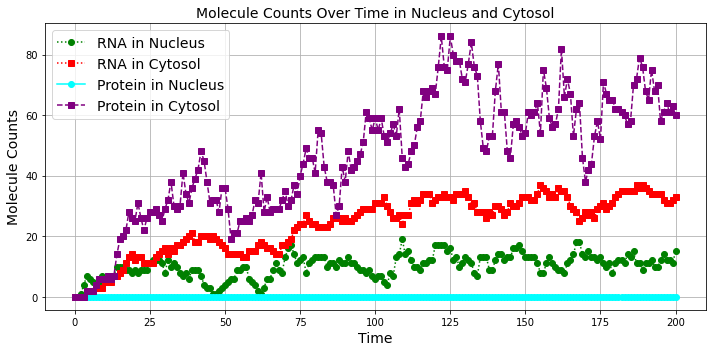

In [9]:
plot_time_courses_all_species(trajectories=results)

In [10]:
def plot_particle_positions(trajectories, simulation_volume_size, masks_nucleus, masks_cytosol, simulation_type='3D', figsize=(12, 12), time_step_index=None, create_gif=False, elev_val=None, azim_val=None, iteration_index=0, output_folder='temp_plots', show_axes=False):
    # Decide if the plot should be 2D or 3D based on the simulation type
    is_3D = simulation_type == '3D'
    
    fig = plt.figure(figsize=figsize)
    if is_3D:
        ax = fig.add_subplot(111, projection='3d', adjustable='box')
    else:
        ax = fig.add_subplot(111)

    # Define colors
    rna_color ='blue'
    protein_color = 'orangered'
    TS_color = 'lime'
    
    def plot_positions(ax, positions, color, label, is_3D, size=10):
        # Check if there are positions to plot
        if positions and len(positions) > 0:
            # Convert positions list to a numpy array directly without trying to extract 'position' from dictionaries
            positions_array = np.array(positions)
            if is_3D:
                # For 3D plots, extract x, y, and z coordinates
                xs, ys, zs = positions_array.T
                ax.scatter(xs, ys, zs, color=color, s=size, label=label, depthshade=False)
            else:
                # For 2D plots, only extract x and y coordinates
                xs, ys = positions_array.T[:2]
                ax.scatter(xs, ys, color=color, s=size, label=label)
        #else:
            # Handle the case where no positions were found for the given time_step_index
            #print(f"No positions found for {label} at the specified time step.")

    def plot_complete_trajectories(ax, trajectory_data, color, is_3D, markersize=1, linewidth=0.5):
        for entity_id, trajectory in trajectory_data.items():
            # Extract positions directly from each dictionary in the trajectory list
            all_positions = np.array([snapshot['position'] for snapshot in trajectory])
            # Ensure there are enough points to form a continuous line
            if len(all_positions) > 1:
                if is_3D:
                    # Plotting for 3D trajectories
                    xs, ys, zs = all_positions.T
                    ax.plot(xs, ys, zs, color=color, linestyle='-', marker='o', markersize=markersize, linewidth=linewidth, label=f"ID {entity_id}")
                else:
                    # Plotting for 2D trajectories
                    xs, ys = all_positions[:, 0], all_positions[:, 1]
                    ax.plot(xs, ys, color=color, linestyle='-', marker='o', markersize=markersize, linewidth=linewidth, label=f"ID {entity_id}")
            else:
                # Handle cases with a single position (plot as a point)
                if len(all_positions) == 1:
                    if is_3D:
                        ax.scatter(all_positions[0][0], all_positions[0][1], all_positions[0][2], color=color, s=markersize, label=f"ID {entity_id}")
                    else:
                        ax.scatter(all_positions[0][0], all_positions[0][1], color=color, s=markersize, label=f"ID {entity_id}")

    # Adjusted for a structure where TS_trajectory is a list of dictionaries
    def plot_TS(TS_trajectory, color=TS_color, time_step_index=None, markersize=50):
        if time_step_index is not None:
            # Accessing 'time' directly from each dictionary in the list
            ts_data = [data for data in TS_trajectory if data['time'] == time_step_index]
            if ts_data:
                ts_info = ts_data[0]  # Assuming at most one entry per time step
                position = ts_info['position']
                ts_color = color if ts_info['state'] else 'gray'
                # Adjust plotting based on dimensionality
                if simulation_type == '3D':
                    ax.scatter(*position, color=ts_color, s=markersize, label='TS', edgecolor='black', zorder=5)
                else:
                    # For 2D, only use the first two coordinates
                    ax.scatter(*position[:2], color=ts_color, s=markersize, label='TS', edgecolor='black', zorder=5)
        else:
            # Plot the entire TS trajectory
            for ts_info in TS_trajectory:  # Adjusted iteration
                position = ts_info['position']
                ts_color = color if ts_info['state'] else 'gray'
                if simulation_type == '3D':
                    ax.scatter(*position, color=ts_color, s=markersize, alpha=0.5, edgecolor='black', zorder=5)
                else:
                    # For 2D, only use the first two coordinates
                    ax.scatter(*position[:2], color=ts_color, s=markersize, alpha=0.5, edgecolor='black', zorder=5)
    
    # Function to plot ellipsoid surface for 3D or contours for 2D
    def plot_surface_or_contour(ax, mask, color, is_3D):
        if is_3D:
            verts, faces, _, _ = measure.marching_cubes(mask, level=0.5, spacing=(1, 1, 1), step_size=1)
            ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], color=color, lw=0.1, alpha=0.02)
        else:
            contours = measure.find_contours(mask, level=0.5)
            for contour in contours:
                ax.plot(contour[:, 0], contour[:, 1], color=color, linewidth=2)
    # Plotting the nucleus and cytosol
    plot_surface_or_contour(ax, masks_nucleus, 'lightcoral', is_3D)
    plot_surface_or_contour(ax, masks_cytosol, 'lightgray', is_3D)

    # Extract RNA and Protein positions for a specific time step or the entire trajectory
    def get_positions_at_time_step(trajectories, time_step_index=None):
        time_steps = trajectories['time_steps']
        RNA_trajectories = trajectories['RNA_trajectories']
        Protein_trajectories = trajectories['Protein_trajectories']
        RNA_positions = []
        Protein_positions = []
        # Helper function to extract positions for a given time step index
        def extract_positions_at_index(entity_trajectories, target_index):
            positions = []
            for entity_list in entity_trajectories.values():
                for snapshot in entity_list:
                    if snapshot['time'] == time_steps[target_index]:
                        positions.append(snapshot['position'])
            return positions
        if time_step_index is not None and time_step_index < len(time_steps):
            RNA_positions = extract_positions_at_index(RNA_trajectories, time_step_index)
            Protein_positions = extract_positions_at_index(Protein_trajectories, time_step_index)
        return RNA_positions, Protein_positions
    
    if time_step_index is not None:
        RNA_positions, Protein_positions = get_positions_at_time_step(trajectories, time_step_index)
        # Plotting positions at a specific time step
        plot_positions(ax, RNA_positions, rna_color, 'RNA', is_3D, 20)
        plot_positions(ax, Protein_positions, protein_color, 'Protein', is_3D, 2)
        plot_TS(trajectories['TS_trajectory'], TS_color, time_step_index=time_step_index, markersize=60)
    else:
        # Plotting complete trajectories for the entire simulation
        plot_complete_trajectories(ax=ax, trajectory_data=trajectories['RNA_trajectories'], color=rna_color, is_3D=is_3D, markersize=1)
        plot_complete_trajectories(ax=ax, trajectory_data=trajectories['Protein_trajectories'], color=protein_color, is_3D=is_3D, markersize=0.5)
        plot_TS(trajectories['TS_trajectory'], TS_color, None, markersize=60)


    # Adjust view for 3D plots
    if is_3D and elev_val is not None and azim_val is not None:
        ax.view_init(elev=elev_val, azim=azim_val)
    
    # Hide or show axes
    if not show_axes:
        ax.set_axis_off()
    else:
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        if is_3D:
            ax.set_zlabel('Z')
        ax.set_title('Particle Positions and Masks')
    
    # Set limits
    ax.set_xlim([0, simulation_volume_size[0]])
    ax.set_ylim([0, simulation_volume_size[1]])
    if is_3D:
        ax.set_zlim([0, simulation_volume_size[2]])
    
    # Saving or showing the plot
    if create_gif:
        os.makedirs(output_folder, exist_ok=True)
        filepath = os.path.join(output_folder, f'image_{iteration_index:04d}.png')
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0)  # Save the figure
        plt.close()
    else:
        plt.show()


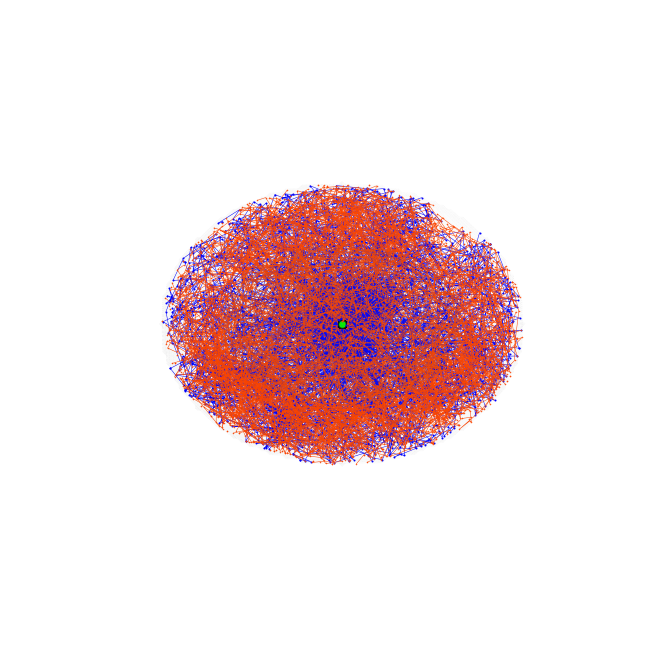

In [11]:
plot_particle_positions( trajectories=results,
                           simulation_volume_size=params['simulation_volume_size'], 
                           masks_nucleus=results['nucleus_mask'], 
                           masks_cytosol=results['cytosol_mask'], 
                           simulation_type=params['simulation_type'],
                           figsize=(12, 12),
                           time_step_index=None,
                           show_axes=False,
                           elev_val=90, 
                           azim_val=-90,)

# To view planes use:
# Plane   Elevation    Vertical
# XY          90         -90
# XZ           0         -90
# YZ           0           0
# Default       30         -37.5

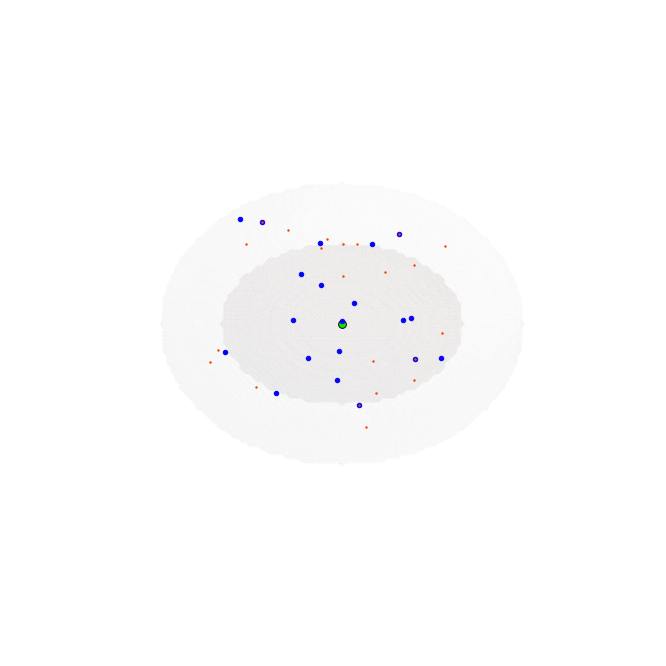

In [12]:
plot_particle_positions( trajectories=results,
                           simulation_volume_size=params['simulation_volume_size'], 
                           masks_nucleus=results['nucleus_mask'], 
                           masks_cytosol=results['cytosol_mask'], 
                           simulation_type=params['simulation_type'],
                           figsize=(12, 12),
                           time_step_index=23,
                           show_axes=False,
                           elev_val=90, 
                           azim_val=-90)

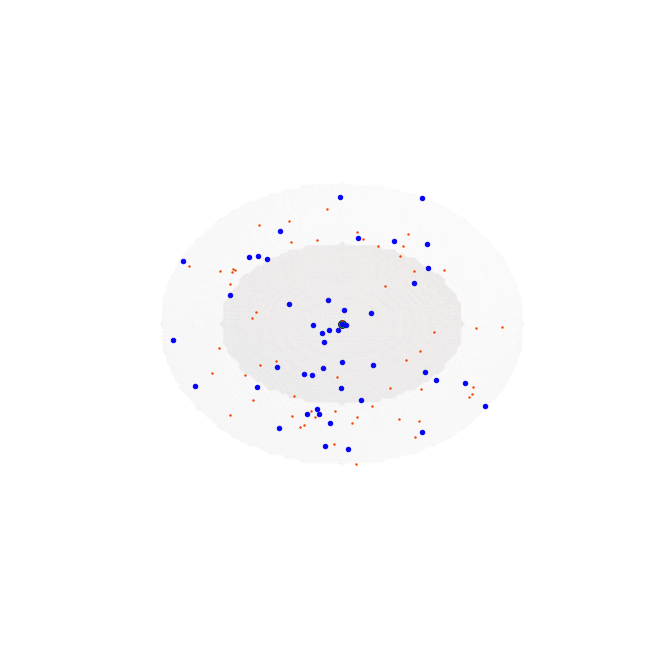

In [13]:
plot_particle_positions( trajectories=results,
                           simulation_volume_size=params['simulation_volume_size'], 
                           masks_nucleus=results['nucleus_mask'], 
                           masks_cytosol=results['cytosol_mask'], 
                           simulation_type=params['simulation_type'],
                           figsize=(12, 12),
                           time_step_index=results['time_steps'][-1],
                           show_axes=False,
                           elev_val=90, 
                           azim_val=-90)

In [14]:
def generate_frame(args):
    trajectories, simulation_volume_size, masks_nucleus, masks_cytosol,simulation_type, figsize, time_step_index, output_folder, index, elevation, azimuth, show_axes = args
    # This function will call your existing plotting function with the appropriate arguments for each frame
    plot_particle_positions( trajectories, simulation_volume_size, masks_nucleus, masks_cytosol,simulation_type, figsize, time_step_index, create_gif=True, elev_val=elevation, azim_val=azimuth, iteration_index=index, output_folder=output_folder, show_axes=show_axes)
    return os.path.join(output_folder, f'image_{index:04d}.png')

def generate_gif_multiprocessing( trajectories, simulation_volume_size, masks_nucleus, masks_cytosol, simulation_type, figsize,time_step_index=None, output_folder='temp_plots', number_steps=18, show_axes=False, rotate_gif=False, time_course_gif=False, max_time=False, gif_filename='animation_cell.gif'):
    if os.path.exists(output_folder):
        for filename in os.listdir(output_folder):
            os.remove(os.path.join(output_folder, filename))
        os.rmdir(output_folder)
    os.makedirs(output_folder, exist_ok=True)
    
    if simulation_type == '2D' and rotate_gif:
        raise ValueError("Cannot rotate a 2D simulation. Set rotate_gif=False.")
    args_list = []
    if rotate_gif:
        iteration_vector = np.linspace(0, 360, number_steps).astype(int)
        for index, azimuth in enumerate(iteration_vector):
            args = (trajectories, simulation_volume_size, masks_nucleus, masks_cytosol,simulation_type, figsize, time_step_index, output_folder, index, 25, azimuth, show_axes)
            args_list.append(args)
    
    if time_course_gif:
        iteration_vector = np.linspace(0, max_time, number_steps).astype(int)
        for index, time_point in enumerate(iteration_vector):
            args = (trajectories, simulation_volume_size, masks_nucleus, masks_cytosol, simulation_type, figsize, time_point, output_folder, index, None, None, show_axes)
            args_list.append(args)

    # Use multiprocessing to generate frames
    with Pool() as pool:
        image_files = pool.map(generate_frame, args_list)

    # Compile the selected images into a GIF
    with imageio.get_writer(gif_filename, mode='I', duration=0.5) as writer:
        for filepath in image_files:
            writer.append_data(imageio.imread(filepath))

    # Optionally, remove the images after creating the GIF
    for filename in os.listdir(output_folder):
        os.remove(os.path.join(output_folder, filename))

    print(f"GIF saved to {gif_filename}")
    return Image(filename=gif_filename)



GIF saved to gif_time_steps.gif


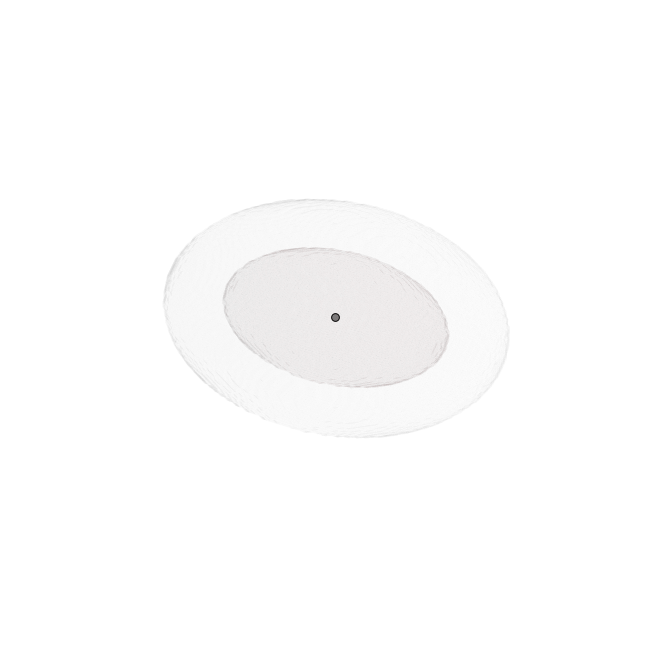

In [15]:
gif_image = generate_gif_multiprocessing(trajectories=results, 
                        simulation_volume_size=params['simulation_volume_size'], 
                        masks_nucleus=results['nucleus_mask'], 
                        masks_cytosol=results['cytosol_mask'], 
                        simulation_type=params['simulation_type'],
                        figsize=(12, 12), 
                        number_steps= (results['time_steps'][-1]-1)//3,
                        output_folder='temp_steps',
                        show_axes=False,
                        rotate_gif=False,
                        time_course_gif = True,
                        max_time = results['time_steps'][-1]-1,
                        gif_filename='gif_time_steps.gif')
display(gif_image)

GIF saved to gif_rotation.gif


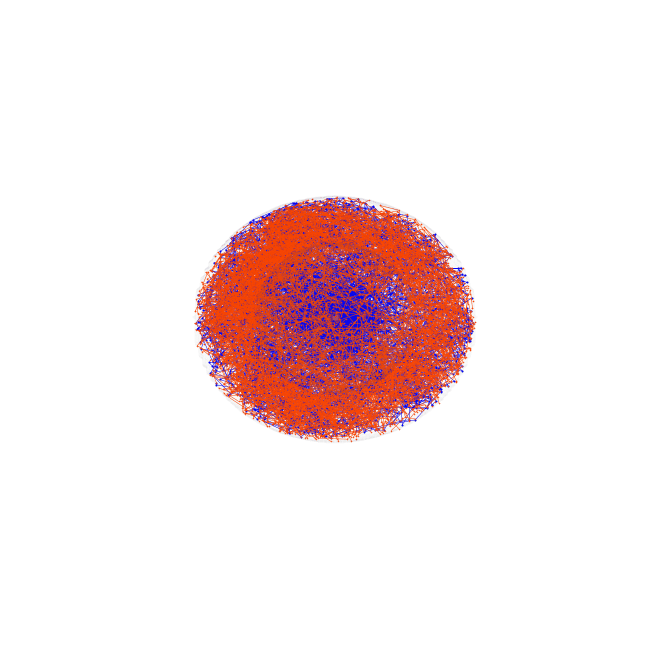

In [16]:
if params['simulation_type'] == '3D':
    gif_image_rot = generate_gif_multiprocessing(trajectories=results, 
                            simulation_volume_size=params['simulation_volume_size'], 
                            masks_nucleus=results['nucleus_mask'], 
                            masks_cytosol=results['cytosol_mask'],
                            simulation_type=params['simulation_type'], 
                            figsize=(12, 12), 
                            time_step_index=None,
                            number_steps= 18,
                            output_folder='temp_rot',
                            show_axes=False,
                            rotate_gif=True,
                            time_course_gif = False,
                            max_time = results['time_steps'][-1]-1,
                            gif_filename='gif_rotation.gif')
    display(gif_image_rot)  

GIF saved to gif_rotation.gif


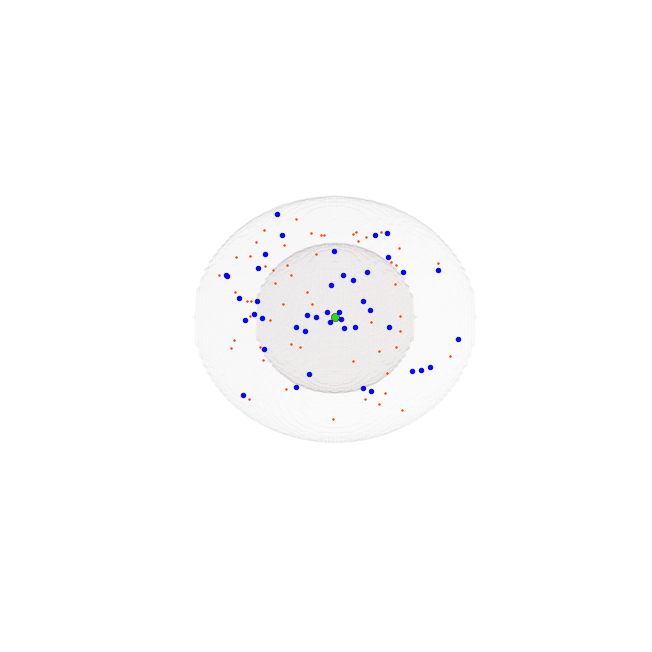

In [17]:
if params['simulation_type'] == '3D':
    gif_image_rot = generate_gif_multiprocessing(trajectories=results, 
                                simulation_volume_size=params['simulation_volume_size'], 
                                masks_nucleus=results['nucleus_mask'], 
                                masks_cytosol=results['cytosol_mask'], 
                                simulation_type=params['simulation_type'],
                                figsize=(12, 12), 
                                time_step_index=results['time_steps'][-1]-20,
                                number_steps= 9,
                                output_folder='temp_rot',
                                show_axes=False,
                                rotate_gif=True,
                                time_course_gif = False,
                                max_time = results['time_steps'][-1]-1,
                                gif_filename='gif_rotation.gif')
    display(gif_image_rot)